In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

import math

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, CNNMnist3
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

%load_ext autoreload
%autoreload 2

class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label

class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 2 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
size of X: (60000, 784)
size of Y: (60000, 10)


alpha_array:  [ 0.70710678 -0.70710678] 

z_array:  [ 1.00000000e+00  8.66025404e-01  5.00000000e-01  6.12323400e-17
 -5.00000000e-01 -8.66025404e-01] 



(-1.2, 1.2)

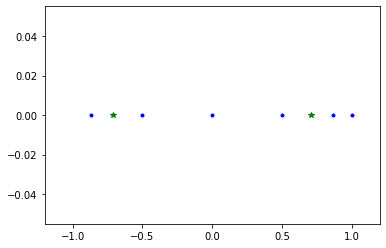

In [4]:
K=2
j_array = np.array(range(K))
# print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*K)) #np.cos((2*j_array+1)*math.pi/(2*K))
print("alpha_array: ",alpha_array,'\n')

N = 6
i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
print("z_array: ",z_array,'\n')

plt.plot(alpha_array, np.zeros(K),'g*',label='alpha')
plt.plot(z_array, np.zeros(N),'b.',label='beta')
plt.xlim([-1.2, 1.2])


alpha_array:  [ 0.70710678 -0.70710678] 

z_array:  [1.000000e+00 6.123234e-17] 



(-1.2, 1.2)

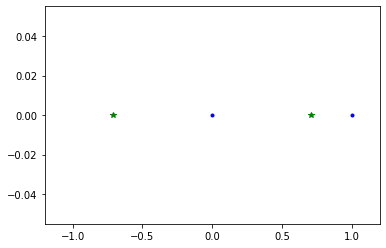

In [5]:
K=2
j_array = np.array(range(K))
# print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*K)) #np.cos((2*j_array+1)*math.pi/(2*K))
print("alpha_array: ",alpha_array,'\n')

N = 2
i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
print("z_array: ",z_array,'\n')

plt.plot(alpha_array, np.zeros(K),'g*',label='alpha')
plt.plot(z_array, np.zeros(N),'b.',label='beta')
plt.xlim([-1.2, 1.2])

In [42]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec, FedAvg_with_LCC_Dec

from utils.functions import *
import math

K = 2
T = 0
sigma = 1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


# j_array = np.array(range(K+T))
# alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

alpha_array = np.array([-5.87785252e-01, 5.87785252e-01])
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2]
alloc_case = 3
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_v0_2 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_v0_2  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx)
        i_array = np.array(range(N))
        z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
#         if N==2:
#             z_array = np.array([-0.88, 0.88])
#         elif N ==4:
#             z_array = np.array([-0.88, -0.25, 0.25, 0.88])
#         elif N ==5:
#             z_array = np.array([-0.88, -0.25, -0.2, 0.25, 0.88])
#         elif N ==6:
#             z_array = np.array([-0.94, -0.88, -0.25, 0.25, 0.88, 0.94])
#         elif N ==7:
#             z_array = np.array([-0.94, -0.88, -0.25, 0, 0.25, 0.88, 0.94])
#         else:
#             z_array = np.array([-0.94, -0.88, -0.25, -0.2, 0.2, 0.25, 0.88, 0.94])

            
        print('z_array:',z_array)        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _is_LCC=False) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True, _is_LCC=False) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()
            
            w_locals_array = []
            w_dec_array = []
            loss_locals_array = []
            w_glob_array = []
            
            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0, alpha_array, z_array, _Noise_Alloc=Noise_Alloc, _is_LCC=False)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])

                
                # update global weights
                
                w_glob, w_dec = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array, is_debug=True)
#                 w_glob = FedAvg_with_LCC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)
        
                w_locals_array.append(w_locals)
                loss_locals_array.append(loss_locals)
                w_dec_array.append(w_dec)
                w_glob_array.append(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v0_2[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v0_2[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0
z_array: [1.000000e+00 6.123234e-17]
@BACC_Enc: N,K,T, m_i= 2 2 0 30000 

@BACC_Enc: N,K,T, m_i= 2 2 0 30000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 2.1019 
Accuracy: 1874/10000 (18.74%)

Round   1, Average loss 2.102 Test accuracy 18.740
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   2, Average loss 2.303 Test accuracy 9.800
selected users: [0 1]

Test set: Average loss: 0.3435 
Accuracy: 8786/10000 (87.86%)

Round   3, Average loss 0.344 Test accuracy 87.860
selected users: [0 1]

Test set: Average loss: 0.0966 
Accuracy: 9746/10000 (97.46%)

Round   4, Average loss 0.097 Test accuracy 97.460
selected users: [0 1]

Test set: Average loss: 0.1020 
Accuracy: 9737/10000 (97.37%)

Round   5, Average loss 0.102 Test accuracy 97.370
selected users: [0 1]

Test set: Avera

In [43]:
loss_test_arr_w_locals = np.zeros((N,N_epochs))
acc_test_arr_w_locals = np.zeros((N,N_epochs))

for i in range(N):
    for iter in range(N_epochs):
        net_glob = CNNMnist2(args=args)
        net_glob.cuda()
#             net_glob.train()
        net_glob.load_state_dict(w_locals_array[iter][i])
        print('N,iter = ',i,iter)
        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        
        loss_test_arr_w_locals[i][iter] = loss_test
        acc_test_arr_w_locals[i][iter] = acc_test

N,iter =  0 0

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

N,iter =  0 1

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

N,iter =  0 2

Test set: Average loss: 3184.0486 
Accuracy: 2627/10000 (26.27%)

N,iter =  0 3

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

N,iter =  0 4

Test set: Average loss: 253556.3036 
Accuracy: 8427/10000 (84.27%)

N,iter =  0 5

Test set: Average loss: 170077.4788 
Accuracy: 8495/10000 (84.95%)

N,iter =  0 6

Test set: Average loss: 142123.7091 
Accuracy: 8386/10000 (83.86%)

N,iter =  0 7

Test set: Average loss: 185399.9298 
Accuracy: 8480/10000 (84.80%)

N,iter =  0 8

Test set: Average loss: 227762.4829 
Accuracy: 8470/10000 (84.70%)

N,iter =  0 9

Test set: Average loss: 181466.7093 
Accuracy: 8407/10000 (84.07%)

N,iter =  0 10

Test set: Average loss: 241658.2456 
Accuracy: 8392/10000 (83.92%)

N,iter =  0 11

Test set: Average loss: 215574.5206 
Accuracy: 8427/10000 (84.27%)

N,iter =  0 12

Test set:

In [44]:
loss_test_arr_w_dec = np.zeros((K,N_epochs))
acc_test_arr_w_dec = np.zeros((K,N_epochs))

for i in range(K):
    for iter in range(N_epochs):
        net_glob = CNNMnist2(args=args)
        net_glob.cuda()
#             net_glob.train()
        net_glob.load_state_dict(w_dec_array[iter][i])
        print('K,iter = ',i,iter)
        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        
        loss_test_arr_w_dec[i][iter] = loss_test
        acc_test_arr_w_dec[i][iter] = acc_test

K,iter =  0 0

Test set: Average loss: 14.4947 
Accuracy: 974/10000 (9.74%)

K,iter =  0 1

Test set: Average loss: 3.5285 
Accuracy: 2453/10000 (24.53%)

K,iter =  0 2

Test set: Average loss: 9558.1242 
Accuracy: 18/10000 (0.18%)

K,iter =  0 3

Test set: Average loss: 1.2962 
Accuracy: 8492/10000 (84.92%)

K,iter =  0 4

Test set: Average loss: 150529.9498 
Accuracy: 21/10000 (0.21%)

K,iter =  0 5

Test set: Average loss: 124896.9692 
Accuracy: 8/10000 (0.08%)

K,iter =  0 6

Test set: Average loss: 83526.5657 
Accuracy: 30/10000 (0.30%)

K,iter =  0 7

Test set: Average loss: 116736.3908 
Accuracy: 14/10000 (0.14%)

K,iter =  0 8

Test set: Average loss: 129993.2498 
Accuracy: 13/10000 (0.13%)

K,iter =  0 9

Test set: Average loss: 99552.1211 
Accuracy: 23/10000 (0.23%)

K,iter =  0 10

Test set: Average loss: 133982.4266 
Accuracy: 18/10000 (0.18%)

K,iter =  0 11

Test set: Average loss: 154376.7374 
Accuracy: 20/10000 (0.20%)

K,iter =  0 12

Test set: Average loss: 144016.413

2


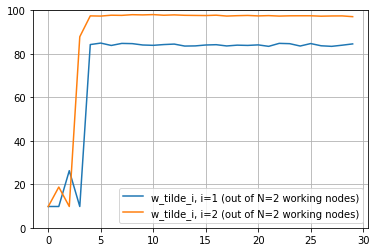

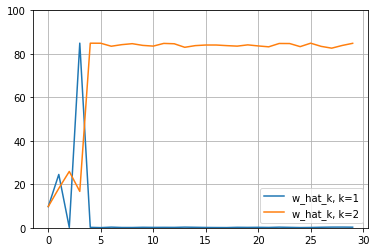

In [51]:
print(K)
# N_array = [2,4,7,10,13]

plt.plot(acc_test_arr_w_locals[0,0:30],  label='w_tilde_i, i=1 (out of N=2 working nodes)')
plt.plot(acc_test_arr_w_locals[1,0:30],  label='w_tilde_i, i=2 (out of N=2 working nodes)')
plt.ylim([0,100])
plt.grid()
plt.legend()
plt.show()


plt.plot(acc_test_arr_w_dec[0,0:30],  label='w_hat_k, k=1')
plt.plot(acc_test_arr_w_dec[1,0:30],  label='w_hat_k, k=2')
plt.ylim([0,100])
plt.grid()
plt.legend()
plt.show()

In [46]:
print((w_dec_array[28][0]['conv1.weight'][0]+w_dec_array[28][1]['conv1.weight'][0])/2)
# print(w_dec_array[0][1]['conv1.weight'][0])
print()
print(w_glob_array[28]['conv1.weight'][0])


tensor([[[-0.0132, -0.0007,  0.0376, -0.0167,  0.0405],
         [-0.0100, -0.2157, -0.6273, -0.7034, -0.4362],
         [-0.2113, -0.4471,  0.4227,  0.5216, -0.4417],
         [-0.1872, -0.0997,  0.2947,  0.2044, -0.3192],
         [-0.2438, -0.0140,  0.2971, -0.0087, -0.0929]]], device='cuda:0')

tensor([[[-0.0132, -0.0007,  0.0376, -0.0167,  0.0405],
         [-0.0100, -0.2157, -0.6273, -0.7034, -0.4362],
         [-0.2113, -0.4471,  0.4227,  0.5216, -0.4417],
         [-0.1872, -0.0997,  0.2947,  0.2044, -0.3192],
         [-0.2438, -0.0140,  0.2971, -0.0087, -0.0929]]], device='cuda:0')
